In [1]:
"""
Created on Apr 17 2023

@author: rodrigo pena
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['savefig.dpi'] = 120
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

torch.manual_seed(0)

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU


In [2]:
ls

classify_IFFL_IFFL_NL.ipynb    iffl_vs_iffl_signal_y.dat
classify_IFFL_IFFL_NL_y.ipynb  M1_R1_lbs.dat
classify_IFFL_NFBL.ipynb       M1_R1_signal.dat
classify_IFFL_NFBL_NL.ipynb    nfbl_vs_nfbl_lbs.dat
classify_IFFL_NFBL_NL_y.ipynb  nfbl_vs_nfbl_lbs_y.dat
classify_NFLB_NFBL_NL.ipynb    nfbl_vs_nfbl_signal.dat
classify_NFLB_NFBL_NL_y.ipynb  nfbl_vs_nfbl_signal_y.dat
gendata_IFFL_NFBL.ipynb        nl_lbs.dat
iffl_vs_iffl_lbs.dat           nl_lbs_y.dat
iffl_vs_iffl_lbs_y.dat         nl_signal.dat
iffl_vs_iffl_signal.dat        nl_signal_y.dat


In [3]:
torch.cuda.is_available()

False

In [4]:
data_cxy = np.loadtxt("iffl_vs_iffl_signal_y.dat").astype(np.float32)
label_cxy = np.loadtxt("iffl_vs_iffl_lbs_y.dat").astype(np.float32)
data_cxy = torch.from_numpy(data_cxy)
label_cxy = torch.from_numpy(label_cxy)

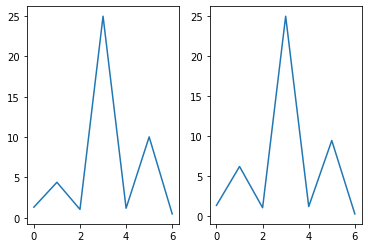

In [5]:
plt.subplot(121)
plt.plot(data_cxy[6])
plt.subplot(122)
plt.plot(data_cxy[7])

In [6]:
data_cxy[:10]

tensor([[ 2.4765,  7.7500,  2.1243, 24.9800,  2.2989, 12.1700,  0.3776],
        [ 2.4217,  8.8900,  2.1128, 24.9700,  2.2662, 13.5200,  0.1715],
        [ 1.4162,  6.1600,  1.1415, 24.9500,  1.2818, 14.0700,  0.3952],
        [ 1.4490,  6.5600,  1.2054, 24.9800,  1.3255,  9.7900,  0.2437],
        [ 1.2861,  4.3300,  1.0072, 24.9700,  1.1473, 12.5500,  0.4758],
        [ 1.3226,  4.8200,  1.0449, 24.9800,  1.1834, 13.3600,  0.3174],
        [ 1.3216,  4.4000,  1.0439, 24.9600,  1.1861, 10.0200,  0.4831],
        [ 1.3344,  6.1900,  1.0372, 24.9800,  1.1845,  9.4400,  0.2626],
        [ 1.8679,  5.9900,  1.5282, 24.9700,  1.7013, 11.2900,  0.3991],
        [ 1.8032, 10.9700,  1.6076, 24.9600,  1.7083, 14.2000,  0.1589]])

In [7]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

class Net_relu(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net_relu,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
class Net_sigmoid(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net_sigmoid,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x    

In [8]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
epochs = 50

model = Net(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (linear1): Linear(in_features=7, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [9]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 7])
b:  torch.Size([10])


In [10]:
my_data_train = []
my_data_val = []
for i in range(len(data_cxy)):
    if i < len(data_cxy)*0.75:
        my_data_train.append([data_cxy[i], label_cxy[i].type(torch.LongTensor)])
    else:    
        my_data_val.append([data_cxy[i], label_cxy[i].type(torch.LongTensor)])

train_set = torch.utils.data.DataLoader(dataset=my_data_train,shuffle=True,batch_size=250)
val_set = torch.utils.data.DataLoader(dataset=my_data_val,shuffle=True,batch_size=250)

In [11]:
len(val_set)

4

# tanh

In [12]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)
epochs = 2000

def train_model(n_epochs):
    for epoch in range(n_epochs):
#         print(epoch)
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

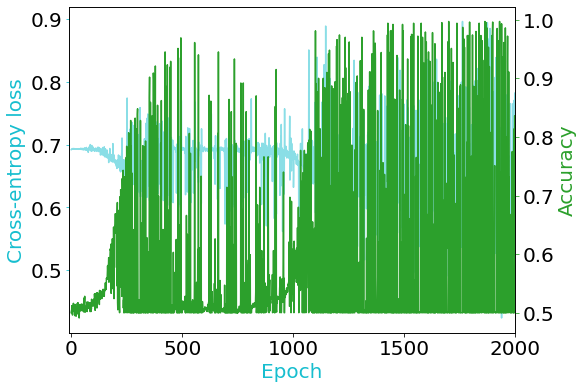

In [13]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('tanh.png')
# plt.savefig('tanh.eps')

In [14]:
accuracy_list[-1]

0.822

# ReLU

In [23]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
# epochs = 50

model = Net_relu(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net_relu(
  (linear1): Linear(in_features=7, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [24]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

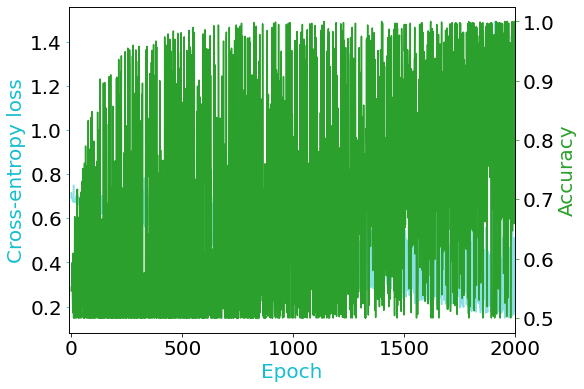

In [25]:

# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('ghs_relu.png')
# plt.savefig('ghs_relu.eps')

In [26]:
accuracy_list[-1]

0.953

# Sigmoid

In [19]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
# epochs = 50

model = Net_sigmoid(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net_sigmoid(
  (linear1): Linear(in_features=7, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [20]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

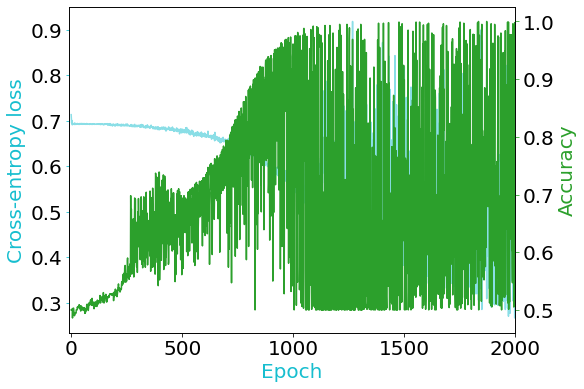

In [21]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('ghs_sigmoid.png')
# plt.savefig('ghs_sigmoid.eps')

In [22]:
accuracy_list[-1]

0.84